[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/42135623-e770e354-7d12-11e8-998d-29fc74429ca2.gif "Trained Agent"


# Collaboration and Competition Report

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. About the problem

Reinforcement learning (RL) has recently been applied to solve challenging problems, from game
playing to robotics. In industrial applications, RL is emerging as a practical component
in large scale systems such as data center cooling. Most of the successes of RL have been in
single agent domains, where modelling or predicting the behaviour of other actors in the environment
is largely unnecessary.

However, there are a number of important applications that involve interaction between multiple
agents, where emergent behavior and complexity arise from agents co-evolving together. For example,
multi-robot control, the discovery of communication and language, multiplayer games, 
and the analysis of social dilemmas  all operate in a multi-agent domain. Related problems,
such as variants of hierarchical reinforcement learning can also be seen as a multi-agent system,
with multiple levels of hierarchy being equivalent to multiple agents. Additionally, multi-agent
self-play has recently been shown to be a useful training paradigm. Successfully scaling RL
to environments with multiple agents is crucial to building artificially intelligent systems that can
productively interact with humans and each other.

For this project, you will work with the [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment.

![Trained Agent][image1]

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those **scores** is at least +0.5.


In [2]:
# Unity ml-agents path
import sys
sys.path.append("../python/")

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 2. Benchmark

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!



In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    t = 0
    while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.array([[t * 0.005, .4 + t*0.01], [t*0.005, .4+t*0.01]])
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        t += 1
        if np.any(dones):                                  # exit loop if episode finished
            print('break at step{}'.format(t))
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

After exploring the game, codes can be simply changed to get a better score instead of random actions. An important information is that junmping action will not be activated entil the action value is larger than 0.5.

When finished, you will get a score around 0.06.

### 3. Solution

MADDPG(Multi-agent DDPG) is the framework of centralized training with
decentralized execution. Thus, we allow the policies to use extra information to ease training, so
long as this information is not used at test time. It is unnatural to do this with Q-learning, as the Q
function generally cannot contain different information at training and test time. Thus, we propose
a simple extension of actor-critic policy gradient methods where the critic is augmented with extra
information about the policies of other agents.

![maddpg](./maddpg.png)

The difference between basic ddpg and maddpg is that critic network will include inputs from other agents as input to train and evaluate.


<img src="./psuedo.png"  height="500" width="800" align='left'>


Basic agent takes DDPG codes from https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum as reference with following modifications.

#### Prioritized Replay

Prioritized replay can make learning from experience replay
more efficient. Here's one possible implementation of prioritized replay.

<img src="./priority.png"  height="500" width="800" align='left'>


### 4. Training and result

This game is different from previous reacher. The episodes end quickly if you don't get any score. So it's difficult to learn based on tick time. I made a `total_t` variable to count all the steps no matter episode ends or not and learn based on that ticks. Due to it's difficult to make a score, I just setup a `LEARN_AFTER` variable to perform random noise certain steps before agent begins to learn.

During the training about 300 episodes(learn after around 230 episodes), I found it's not learning at all. The actor and critic loss are plotting after running process. The losses are increasing or fluctuating. The predicted actions are all -1 or 1 which makes agents perform even worse than noise.

In [9]:
# from maddpg_agent import *

import matplotlib.pyplot as plt
%matplotlib inline
import time


def train(n_episodes=500, max_t=1000, random_seed=1, agent=None, debug=False):
    if agent == None:
        agent = [Agent(state_size=state_size, action_size=action_size, 
                          random_seed=random_seed, 
                       num_agents=num_agents, agent_index=i) for i in range(num_agents)]
        
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_ave = []
    scores_agent = []
    c_loss_plot = []
    a_loss_plot = []
    total_t = 0
    
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        time_start = time.time()
        for _ in range(max_t):
            total_t += 1
            actions = [ agent[i].act(states[i]) for i in range(num_agents) ]
            actions = np.vstack(actions)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            states = next_states
            scores += rewards
            
            for i in range(num_agents):
                c_loss, a_loss = agent[i].step(states[i], states, 
                                               actions[i], actions, 
                                            rewards[i], next_states[i], next_states, 
                                            dones[i], timestep=total_t)            
                
                if np.any(c_loss): 
                    c_loss_plot += c_loss
                if np.any(a_loss): 
                    a_loss_plot += a_loss
                
            if np.any(dones):
                break
            
        duration = time.time() - time_start
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_ave.append(np.mean(scores_window))
        scores_agent.append(scores)
                
        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f} Batch Size: {} {}'.format(i_episode, 
                                    round(duration), np.min(scores), 
                                     np.max(scores), np.mean(scores), 
                                     np.mean(scores_window), 
                                     format(len(agent[0].memory)), ' '*10), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}\
                \tTimestep: {}'.format(i_episode, 
                                       np.mean(scores_window), 
                                       total_t))
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            for i in range(num_agents):
                plt.plot(np.arange(len(np.vstack(scores_agent))), 
                         np.vstack(scores_agent)[:,i], label='Agent {}'.format(i+1))
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            ax.legend()
            plt.show()
            
            if len(c_loss_plot):
                # c loss
                c_loss_agents = np.array(c_loss_plot).reshape(num_agents, -1)
#                 print(c_loss_agents)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(c_loss_agents[i])), c_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Q')
                ax.legend()
                plt.show()
            
            if len(a_loss_plot):
                # a loss
                a_loss_agents = np.array(a_loss_plot).reshape(num_agents, -1)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(a_loss_agents[i])), a_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Policy')
                ax.legend()
                plt.show()
            
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}_{}.pth'.format(i, i_episode))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}_{}.pth'.format(i, i_episode))

        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}.pth'.format(i))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}.pth'.format(i))
            break
            
    return scores_ave, agent


In [139]:
def play(play_agent, t=10):
    # trained model
    # play times
    for i in range(t):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
#             actions = play_agent.act(states, add_noise=False)                  # all actions between -1 and 1
            actions = [ play_agent[i].act(states[i], add_noise=False) for i in range(num_agents) ]
            actions = np.vstack(actions)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (sum over agents) from episode {}: {:.2f}'.format(i, np.sum(scores)))

#### Experiment 7

MADDPG + PER

Hyperparameters:

```python
BUFFER_SIZE = 2**17  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 20        # learning timestep interval
LEARN_NUM = 10          # number of learning passes
LEARN_AFTER = 0
SEED = 1
```

In [145]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

Episode 100(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 1841           
Episode 100	Average Score: -0.00                	Timestep: 1841


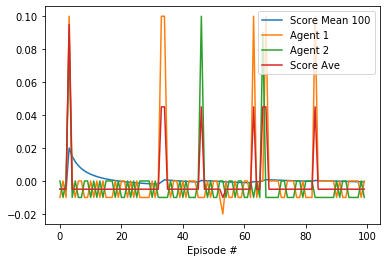

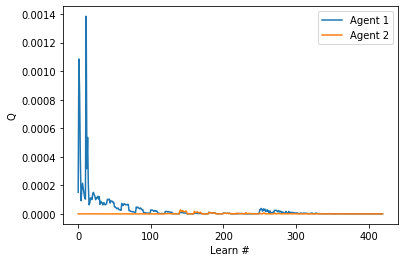

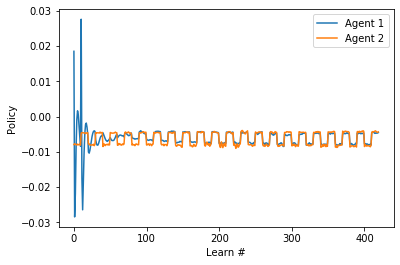

Episode 200(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 3790            
Episode 200	Average Score: 0.00                	Timestep: 3790


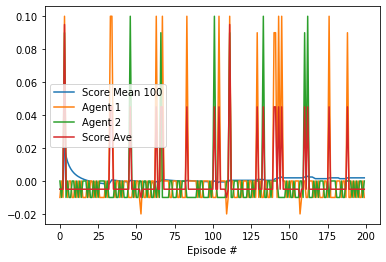

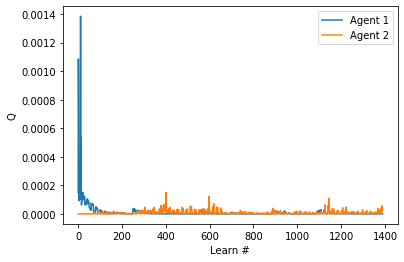

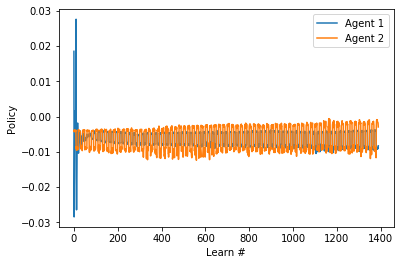

Episode 300(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 5720           
Episode 300	Average Score: 0.00                	Timestep: 5720


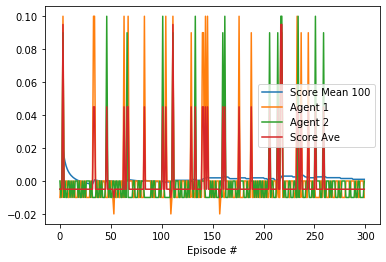

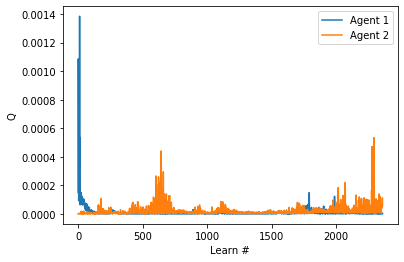

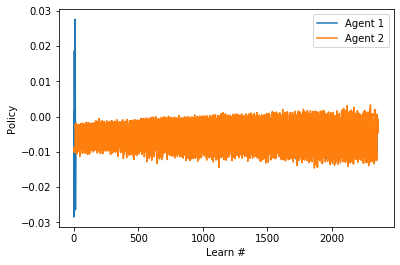

In [146]:
scores_ave, agent = train(n_episodes=300, random_seed=SEED)

In [147]:
# read model weights
best_agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents, agent_index=0)
best_agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents, agent_index=1)
actor_state_dict_0 = torch.load('./actor0_300.pth')
actor_state_dict_1 = torch.load('./actor1_300.pth')
# actor_state_dict_0 = torch.load('./experiment_7/actor0_5000.pth')
# actor_state_dict_1 = torch.load('./experiment_7/actor1_5000.pth')
best_agent_0.actor_local.load_state_dict(actor_state_dict_0)
best_agent_1.actor_local.load_state_dict(actor_state_dict_1)

play([best_agent_0, best_agent_1], t=20)

Score (sum over agents) from episode 0: -0.01
Score (sum over agents) from episode 1: 0.09
Score (sum over agents) from episode 2: -0.01
Score (sum over agents) from episode 3: -0.01
Score (sum over agents) from episode 4: -0.01
Score (sum over agents) from episode 5: -0.01
Score (sum over agents) from episode 6: -0.01
Score (sum over agents) from episode 7: -0.01
Score (sum over agents) from episode 8: -0.01
Score (sum over agents) from episode 9: -0.01
Score (sum over agents) from episode 10: -0.01
Score (sum over agents) from episode 11: -0.01
Score (sum over agents) from episode 12: -0.01
Score (sum over agents) from episode 13: -0.01
Score (sum over agents) from episode 14: -0.01
Score (sum over agents) from episode 15: -0.01
Score (sum over agents) from episode 16: -0.01
Score (sum over agents) from episode 17: -0.01
Score (sum over agents) from episode 18: 0.09
Score (sum over agents) from episode 19: -0.01


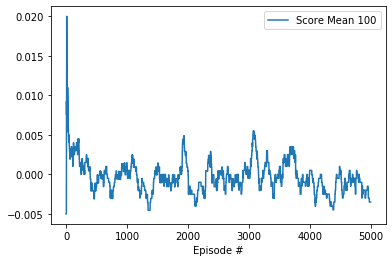

In [141]:
fig, ax = plt.subplots()

plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
plt.xlabel('Episode #')

ax.legend()
plt.show()


In [ ]:
env.close()

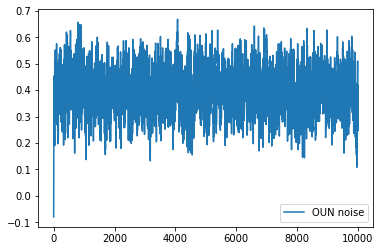

In [128]:
# To test OUNoise hyperparameters
oun = OUNoise(size=1, seed=1, mu=-0.1, theta=0.15, sigma=0.15)
cnt = 10000
result = []
for _ in range(cnt):
    r = oun.sample()
    result.append(r)

fig, ax = plt.subplots()
plt.plot(np.arange(cnt), result, label='OUN noise')

ax.legend()
plt.show()